In [1]:
import sys
sys.path.append('../')

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
import cv2

from scipy import ndimage, fft

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


#### Experiment #1 : Symmetric Convolution


TensorShape([50, 50])

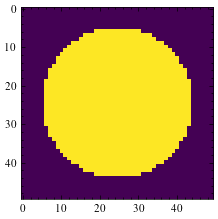

In [2]:
'''img = np.zeros((45, 45))
center_coordinates = (img.shape[0]//2, img.shape[1]//2) 
img = cv2.circle(img, center_coordinates, 20, (255,255,255), -1) 
plt.imshow(img)'''


N = 50
#img =  tf.image.rot90(tf.random.uniform(shape=(50,50,1), minval=0., maxval=1.), k=1) #
#img = tf.image.pad_to_bounding_box(img, 25//2,25//2,N+25, N+25)[...,0]

img =  tf.expand_dims(cv2.imread('input4.png', 0)/255. , axis=-1)
H, W, C = img.shape  # Get image dimensions
offset_height = (H - N) // 2
offset_width = (W - N) // 2
img = tf.image.crop_to_bounding_box(img, offset_height, offset_width, N, N)[...,0]
plt.imshow(img)
img.shape


(50, 50)


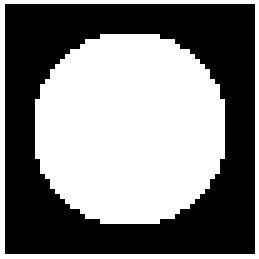

In [3]:
#var = 2/(128*9)

fig,ax = plt.subplots(1)

ax.imshow(img, cmap='gray')

#img = (img-np.mean(img))/np.std(img)
#img = tf.repeat(tf.expand_dims([img], axis=-1) , repeats = 512, axis=-1)  #get_double_slit(shape) , axis=0)
print(img.shape)
plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("input.png",bbox_inches='tight',   pad_inches = 0)


Original shape: (500, 500)


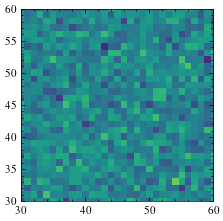

In [4]:
img = np.random.normal(loc=0.0, scale=1.0, size=(500, 500))
print("Original shape:", img.shape)

# Pad with 10 pixels of zeros on all sides
img = np.pad(img, pad_width=((10, 10), (10, 10)), mode='constant', constant_values=0)

fig, ax = plt.subplots()
ax.imshow(img)
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.show()

In [5]:
'''img  = np.zeros((7, 7)) # np.random.uniform(low=0, high=1, size=(50,50,10))
img[3, 3 ]=1.

plt.imshow(img)'''

'img  = np.zeros((7, 7)) # np.random.uniform(low=0, high=1, size=(50,50,10))\nimg[3, 3 ]=1.\n\nplt.imshow(img)'

In [6]:
w = np.zeros((3,3,1,1))


t1 = np.zeros((3,3))
t2 = np.zeros((3,3))

'''t1[1, 2] = 1.
t2[2, 1] = 1.'''
t1[1,0] = 1.
t2[0, 1] = 1.


w1 = fft.idctn(t1, norm='ortho')
#w1 /= np.sum(np.abs(w1))

w2 = fft.idctn(t2, norm='ortho')
#w2 /= np.sum(np.abs(w2))

w[:,:,0,0] = (np.cos(-np.pi))*w1 + ( np.sin(-np.pi))*w2
print(tf.math.reduce_euclidean_norm(w))
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))


print(tf.math.reduce_euclidean_norm(w))
x = img

print("IMG", (tf.math.reduce_euclidean_norm(img)))



directory = f"figures/malus_high_order"
if not os.path.exists(directory):
	os.makedirs(directory)


response_mag = []
init_mag = tf.math.reduce_euclidean_norm(x).numpy()



i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

print("I0,", tf.math.reduce_euclidean_norm(i0))


i1 = tf.nn.relu(tf.nn.conv2d(i0, w , strides=(1,1), padding='SAME') )

print("I1,", tf.math.reduce_euclidean_norm(i1))



init_mag = tf.math.reduce_euclidean_norm(i1).numpy()

angles = np.linspace(-np.pi, np.pi, 100)
for i in range(100):
	#fig, ax = plt.subplots()
	
	
	w[:,:,0,0] = (np.cos(angles[i]))*w1 + ( np.sin(angles[i]))*w2
	w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))
		
	x_out = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
								padding='SAME') )

	response_mag.append(tf.math.reduce_euclidean_norm(x_out).numpy()/init_mag)
	print(tf.math.reduce_euclidean_norm(x_out).numpy(), response_mag[-1])

tf.Tensor(0.9999999999999999, shape=(), dtype=float64)
tf.Tensor(1.0, shape=(), dtype=float64)
IMG tf.Tensor(500.9660491229154, shape=(), dtype=float64)
I0, tf.Tensor(500.96603, shape=(), dtype=float32)
I1, tf.Tensor(354.5613, shape=(), dtype=float32)
337.61478 0.9522042
337.06375 0.9506501
335.4668 0.9461461
332.8349 0.93872315
329.1859 0.9284316
324.54526 0.9153431
318.94647 0.8995524
312.43103 0.8811763
305.04794 0.8603532
296.85593 0.8372485
287.92468 0.8120589
278.33405 0.7850096
268.17642 0.7563612
257.55847 0.7264145
246.60237 0.695514
235.4498 0.66405946
224.26482 0.6325135
213.23698 0.60141075
202.58543 0.5713693
192.56021 0.5430943
183.43681 0.5173628
175.51021 0.49500665
169.08154 0.47687533
164.43564 0.4637721
161.80095 0.45634124
161.32469 0.45499802
163.03877 0.45983237
166.83922 0.4705511
172.53358 0.48661143
179.8592 0.50727254
188.51785 0.5316932
198.20543 0.5590159
208.63426 0.5884293
219.54297 0.61919606
230.70123 0.6506667
241.90845 0.68227535
252.99088 0.7135321
26

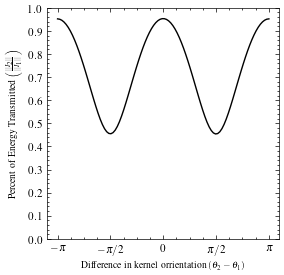

In [7]:
fig, ax= plt.subplots(1,1, figsize=(3,3))

ax.plot(angles,response_mag)

ticks = np.arange(-np.pi, 1.5*np.pi, np.pi/2)
labels = [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"]
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels);
ax.set_yticks(ticks=np.arange(0,1.1, 0.1));

ax.set_ylabel(r"Percent of Energy Transmitted $\left( \frac{||I_{2}||}{||I_{1}||} \right)$", fontsize=7)
ax.set_xlabel(r"Difference in kernel orrientation $(\theta_2 - \theta_1)$", fontsize=7)

plt.savefig('malus2_high_order.pdf', dpi=600)
plt.show()


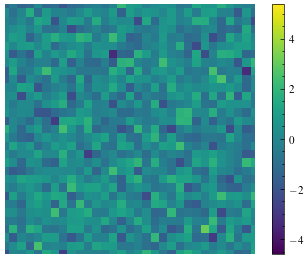

In [8]:
i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

fig, ax= plt.subplots(1,1)


im =ax.imshow(i0[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i0_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)


tf.Tensor(500.96603, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=354.5613>

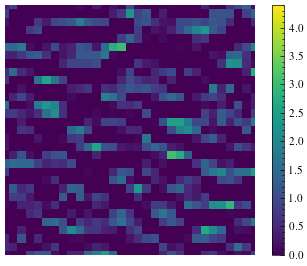

In [9]:
angle = -np.pi

w = np.zeros((3,3,1,1))

w[:,:,0,0] = (np.cos(angle))*w1 + ( np.sin(angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))


i0 = tf.cast(tf.repeat(tf.expand_dims([img], axis=-1) , repeats = w.shape[-2], axis=-1), dtype=tf.float32) 

print((tf.math.reduce_euclidean_norm(i0)))

i1 = tf.nn.relu( tf.nn.conv2d(i0, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i1[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');




ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i1_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
tf.math.reduce_euclidean_norm(i1)



<tf.Tensor: shape=(), dtype=float32, numpy=338.0362>

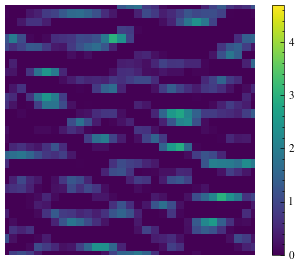

In [17]:
angle = 0

w[:,:,0,0] = (np.cos(angle))*w1 + ( np.sin(angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))




i2 = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));
x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i2_y_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)
tf.math.reduce_euclidean_norm(i2)

<tf.Tensor: shape=(), dtype=float32, numpy=337.61478>

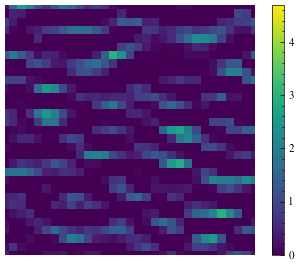

In [11]:
angle = np.pi
w = np.zeros((3,3,1,1))
w[:,:,0,0] = (np.cos(angle))*w1 + ( np.sin(angle))*w2
w[:,:,0,0] = w[:,:,0,0] / (tf.math.reduce_euclidean_norm(w))



i2 = tf.nn.relu( tf.nn.conv2d(i1, w , strides=(1,1), 
							 padding='SAME') )


fig, ax= plt.subplots(1,1)

im =ax.imshow(i2[0,...,0])
#ax.plot(45//2, 45, marker = '+', color='red');



#ax.set(xlim=(0, img.shape[0]), ylim=(0,  img.shape[1]));

x_min, x_max = 30, 60
y_min, y_max = 30, 60

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)


fig.colorbar(im, orientation='vertical');

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig("i2_x_high_order.pdf",bbox_inches='tight',   pad_inches = 0, dpi=600)

tf.math.reduce_euclidean_norm(i2)

In [12]:
w[:,:,0,0] 

array([[-4.08248290e-01, -4.08248290e-01, -4.08248290e-01],
       [ 1.28500619e-16,  7.85046229e-17,  2.85086267e-17],
       [ 4.08248290e-01,  4.08248290e-01,  4.08248290e-01]])

(-0.5, 2.5, 2.5, -0.5)

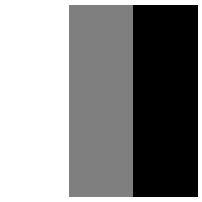

In [13]:
w[:,:,0,0] = (np.cos(np.pi/2))*w1 + ( np.sin(np.pi/2))*w2





plt.imshow(w[:,:,0,0], cmap='gray')
plt.axis('off')



array([[[[ 1.36082763e-01]],

        [[-1.85037171e-17]],

        [[-1.36082763e-01]]],


       [[[ 1.36082763e-01]],

        [[-1.85037171e-17]],

        [[-1.36082763e-01]]],


       [[[ 1.36082763e-01]],

        [[-1.85037171e-17]],

        [[-1.36082763e-01]]]])

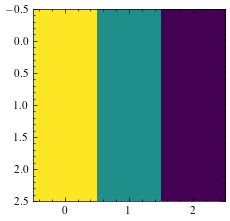

In [14]:
a = np.zeros((3,3))
a[0, 1] =1
a = np.reshape(fft.idctn(a, norm='ortho'), (3,3,1,1))

b = np.zeros((3,3))
b[0, 0] =1
b = np.reshape(fft.idctn(b, norm='ortho'), (3,3,1,1))

dct_basis = a*b

plt.imshow(dct_basis[..., 0,0])
dct_basis